In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap
from matplotlib import cm
%matplotlib inline

import numpy as np
import scipy.stats as sp

import math
from collections import namedtuple
from functools import partial

In [2]:
data = pd.read_csv("prices.txt")

X = np.column_stack((data.values[:,:2].astype(np.float64), np.repeat(1, data.shape[0])))
Y = data.values[:,2].astype(np.float64)

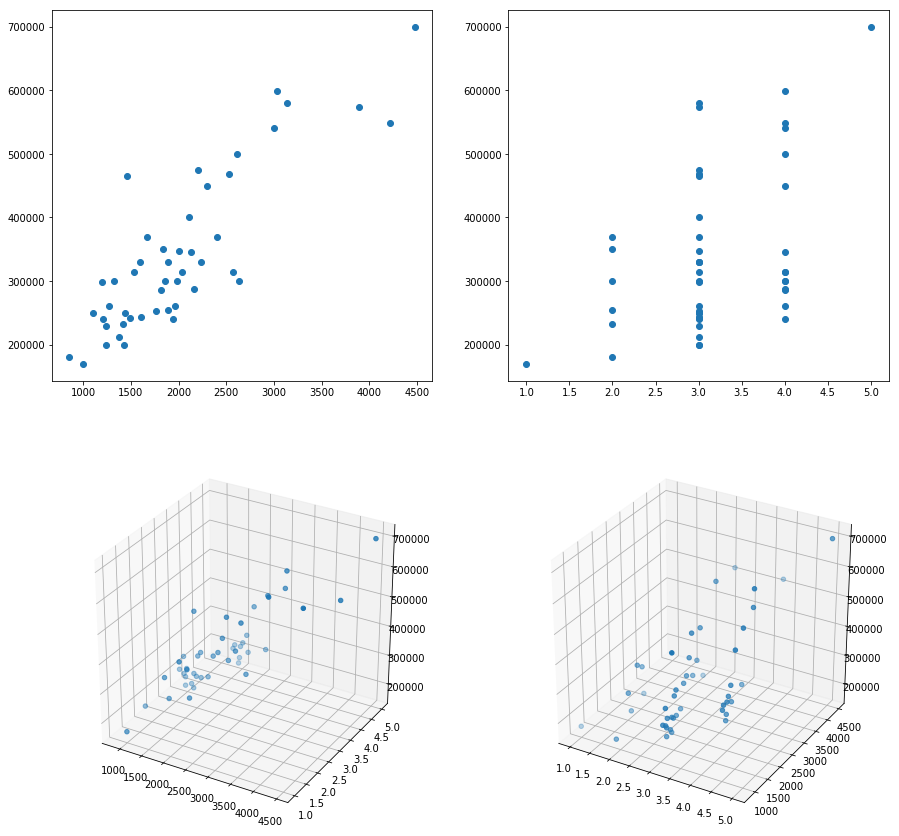

In [3]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221)
ax.scatter(X[:,0], Y)
ax = fig.add_subplot(222)
ax.scatter(X[:,1], Y)
ax = fig.add_subplot(223, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)
ax = fig.add_subplot(224, projection='3d')
ax.scatter(X[:,1], X[:,0], Y)

$$
X = \mathbb{R}^2, Y = \mathbb{R} \\
A=\{g(x, \theta) \mid \theta \in \Theta\} \\
\Theta = \mathbb{R}^3 \\
g(x, \theta) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 \\
Q(\theta, T^l) = \frac{1}{l}\sum_{i=1}^l \left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right)^2 \\
\frac{\partial\left(ax+b\right)^2}{\partial x}
= \frac{\partial\left(a^2x^2+2abx+b^2\right)}{\partial x}
= 2a^2x+2ab
= 2a(ax+b)  \\
\begin{align*}
\nabla Q(\theta) &=
\left(
\frac{2}{l}\sum_{i=1}^l x_0^i\left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right);
\frac{2}{l}\sum_{i=1}^l x_1^i\left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right);
\frac{2}{l}\sum_{i=1}^l \left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right)
\right) \\
 &= \frac{2}{l}\left(\theta \cdot X'^\mathrm{T} - y\right) \cdot X',\text{ где } X' = X||1^l
\end{align*}
$$

In [4]:
EPS = 1e-10
MAX_STEP_N = 10000
ALPHA = 0.2

def deviation(X, Y, theta):
    return np.sqrt(1/X.shape[0] * np.sum(((np.dot(theta, X.T)- Y) ** 2), 1))

def loss_gradient(X, Y, theta):
    return 2/X.shape[0] * (theta.dot(X.T) - Y).dot(X)

def gradient_descent(X, Y, theta):
    step_n = 0
    thetas = [theta]
    while True:
        new_theta = theta - ALPHA * loss_gradient(X, Y, theta)
        thetas.append(new_theta)
        step_n += 1
        if (np.linalg.norm(new_theta - theta) < EPS or step_n >= MAX_STEP_N):
            return new_theta, np.array(thetas)
        theta = new_theta

In [5]:
TRY_N = 1
SEED = 0

np.random.seed(SEED)
Theta0 = (np.random.rand(TRY_N, X.shape[1]) - 0.5) * 2

def normalize_columns(X):
    k = np.max(X, 0)
    return k, X / k

Xk, Xn = normalize_columns(X)
Yk, Yn = normalize_columns(Y)

best_deviation = 1e9
best_theta = []
best_curve = []
for theta in Theta0:
    optimized_theta, optimized_curve = gradient_descent(Xn, Yn, theta)
    optimized_deviation = deviation(Xn, Yn, [optimized_theta])
    if optimized_deviation < best_deviation:
        best_deviation = optimized_deviation
        best_theta = optimized_theta
        best_curve = optimized_curve
        
best_theta = best_theta * Yk / Xk
best_deviation = deviation(X, Y, [best_theta])
best_curve = best_curve * Yk / Xk

In [6]:
print(best_theta, best_deviation)

[   139.21067211  -8738.01649452  89597.90501157] [ 63926.20824987]


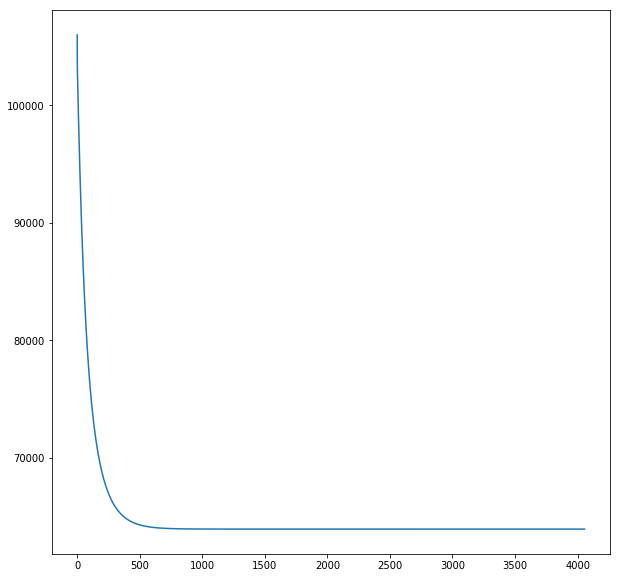

In [7]:
curve_deviations = deviation(X, Y, best_curve)
plt.figure(figsize=(10, 10))
plt.plot(np.arange(0, curve_deviations.shape[0]), curve_deviations)

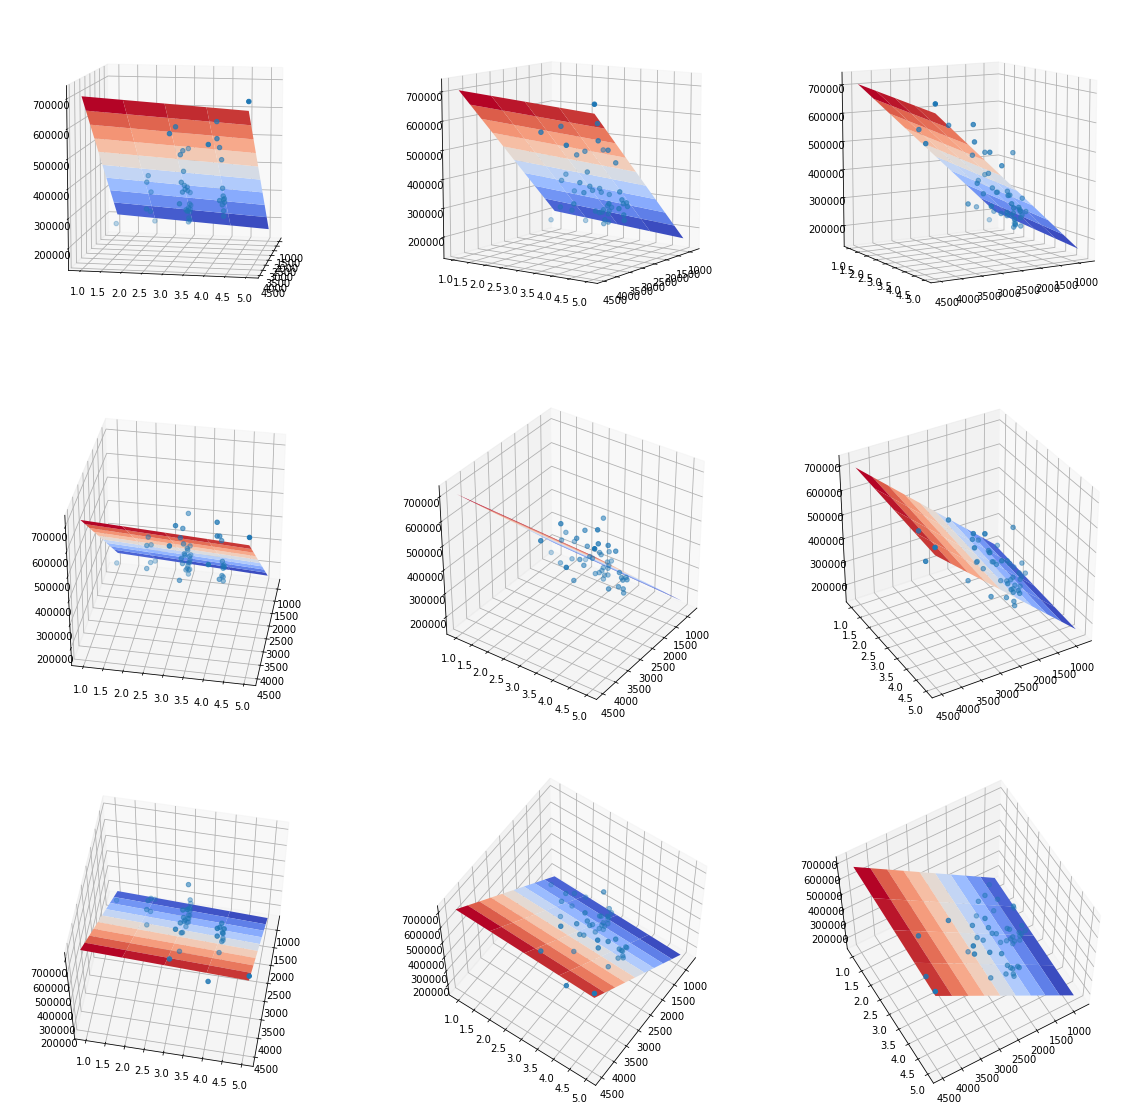

In [8]:
xmin = np.min(X, 0)
xmax = np.max(X, 0)
areas = np.linspace(xmin[0], xmax[0], 10)
rooms = np.linspace(xmin[1], xmax[1], 5)
areas, rooms = np.meshgrid(areas, rooms)
areas1 = areas.reshape((-1))
rooms1 = rooms.reshape((-1))
points = np.column_stack((areas1, rooms1, np.repeat(1, areas1.shape[0]))).T
prices = best_theta.dot(points).reshape(areas.shape)

ANGLE_N = 3
MIN_ANGLE = 10
MAX_ANGLE = 60
fig = plt.figure(figsize=(20, 20))
i = 1
for angle1 in np.linspace(MIN_ANGLE, MAX_ANGLE, ANGLE_N):
    for angle2 in np.linspace(MIN_ANGLE, MAX_ANGLE, ANGLE_N):
        ax = fig.add_subplot(ANGLE_N, ANGLE_N, i, projection='3d')
        i += 1
        ax.view_init(angle1, angle2)
        ax.scatter(X[:,0], X[:,1], Y)
        ax.plot_surface(areas, rooms, prices, cmap=cm.coolwarm)
plt.show()